Philippe Joly 27-09-24

This is the implementation of Zhang's thinning/skeletonization algorithm

In [52]:
import matplotlib.pyplot as plt
import numpy as np

import skimage.io as io
from skimage.filters import sobel
from skimage.color import rgb2gray
from skimage.segmentation import watershed
from skimage import morphology

from scipy import ndimage

In [53]:
i=1

In [54]:
img_original =  io.imread(f'./examples/{i}_knot.png')[...,:3]      
img_gray = rgb2gray(img_original)

## Region-Based Segmentation

In [55]:
def blur(img, k_size, blur_size):
    kernel = np.ones((k_size,k_size))

    closing = ndimage.binary_closing(img, structure=kernel)
    opening = ndimage.binary_opening(closing, structure=kernel)

    result = ndimage.median_filter(opening, size=blur_size)

    return result

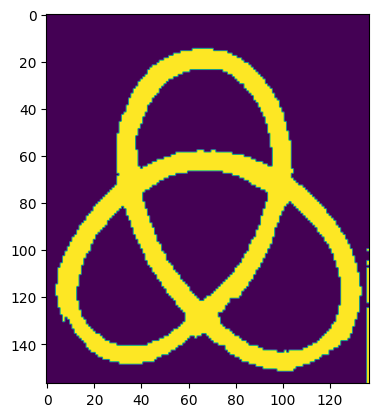

In [56]:
elevation_map = sobel(img_gray)

markers = np.zeros_like(img_gray)
markers[img_gray<30/255]=1
markers[img_gray>150/255]=2
markers = markers.astype(np.int32)

bw = watershed(elevation_map, markers)-1
# bw = blur(bw, 10, 16)
plt.imshow(bw)

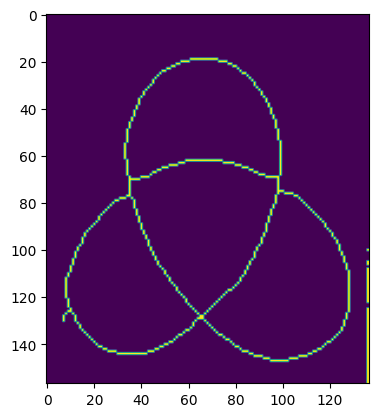

In [57]:
skeleton = morphology.skeletonize(bw)
plt.imshow(skeleton)

## Zhang's Algorithm 

In [58]:
def neighbours(x,y,image):
    # "Return 8-neighbours of image point P1(x,y), in a clockwise order"
    img = image
    x_1, y_1, x1, y1 = x-1, y-1, x+1, y+1
    return [ img[x_1][y], img[x_1][y1], img[x][y1], img[x1][y1],     # P2,P3,P4,P5
                img[x1][y], img[x1][y_1], img[x][y_1], img[x_1][y_1] ]    # P6,P7,P8,P9

def transitions(neighbours):
    # "No. of 0,1 patterns (transitions from 0 to 1) in the ordered sequence"
    n = neighbours + neighbours[0:1]      # P2, P3, ... , P8, P9, P2
    return sum( (n1, n2) == (0, 1) for n1, n2 in zip(n, n[1:]) )  # (P2,P3), (P3,P4), ... , (P8,P9), (P9,P2)

def zhangSuen(image):
    # "the Zhang-Suen Thinning Algorithm"
    Image_Thinned = image.copy()  # deepcopy to protect the original image
    changing1 = changing2 = 1        #  the points to be removed (set as 0)
    while changing1 or changing2:   #  iterates until no further changes occur in the image
        # Step 1
        changing1 = []
        rows, columns = Image_Thinned.shape               # x for rows, y for columns
        for x in range(1, rows - 1):                     # No. of  rows
            for y in range(1, columns - 1):            # No. of columns
                P2,P3,P4,P5,P6,P7,P8,P9 = n = neighbours(x, y, Image_Thinned)
                if (Image_Thinned[x][y] == 1     and    # Condition 0: Point P1 in the object regions 
                    2 <= sum(n) <= 6   and    # Condition 1: 2<= N(P1) <= 6
                    transitions(n) == 1 and    # Condition 2: S(P1)=1  
                    P2 * P4 * P6 == 0  and    # Condition 3   
                    P4 * P6 * P8 == 0):         # Condition 4
                    changing1.append((x,y))
        for x, y in changing1: 
            Image_Thinned[x][y] = 0
        # Step 2
        changing2 = []
        for x in range(1, rows - 1):
            for y in range(1, columns - 1):
                P2,P3,P4,P5,P6,P7,P8,P9 = n = neighbours(x, y, Image_Thinned)
                if (Image_Thinned[x][y] == 1   and        # Condition 0
                    2 <= sum(n) <= 6  and       # Condition 1
                    transitions(n) == 1 and      # Condition 2
                    P2 * P4 * P8 == 0 and       # Condition 3
                    P2 * P6 * P8 == 0):            # Condition 4
                    changing2.append((x,y))    
        for x, y in changing2: 
            Image_Thinned[x][y] = 0
    return Image_Thinned

## Results

In [59]:
skeleton = zhangSuen(bw)
fig, ax = plt.subplots(1, 3)
ax1, ax2, ax3 = ax.ravel()
ax1.imshow(img_original)
ax1.set_title('Original Image')
ax1.axis('off')

ax2.imshow(bw)
ax2.set_title('Binary Image')
ax2.axis('off')

ax3.imshow(skeleton)
ax3.set_title('Image Skeleton')
ax3.axis('off')
plt.show()